Imports & Setup

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import requests
import os

seed = 42

download = True	# Flag to download or create the graph from local file
graph_url = "https://github.com/SorenLKuhl/imdb_network/raw/refs/heads/main/imdb_movie_network.pkl"

# Download backboning script
bb_url = "https://raw.githubusercontent.com/SorenLKuhl/RockBandWikiData/refs/heads/main/backboning.txt"
bb_response = requests.get(bb_url)
bb_response.raise_for_status()
with open("backboning.py", 'w') as f:
    f.write(bb_response.text)

import backboning

We load the tsv containing the movies of interest.

In [154]:
if download:
	print("Do nothing for now - download graph from GitHub later")
else:
	path = "../datasets/final_filtered_movies_with_reviews.tsv"
	movies_df = pd.read_csv(path, sep="\t")
	print(f"Number of movies: {len(movies_df)}")
	print(movies_df.head())

Do nothing for now - download graph from GitHub later


Now we create an undirected networkx graph with the movies as nodes and actors as links. We save the accompanying data as attributes on the nodes.

In [155]:
G: nx.Graph = nx.Graph()	# Undirected as links are actors in common
if download:
	# Download the pickled graph from GitHub
	response = requests.get(graph_url)
	response.raise_for_status()  # Ensure we got a successful response
	G = pickle.loads(response.content)
	G = G.copy()  # To make the graph writable
else:
	# Create mapping of actors to movies
	actor_to_movies = {}

	for idx, row in movies_df.iterrows():

		# Add movie as node with attributes
		id = row['tconst']
		title = row['primaryTitle']
		original_title = row['originalTitle']
		avg_rating = row['averageRating']
		num_ratings = row['numVotes']
		actors = row['nconst'].split(', ') if 'nconst' in row and pd.notna(row['nconst']) else []
		reviews = row['top20_reviews_en'].split('|||') if 'top20_reviews_en' in row and pd.notna(row['top20_reviews_en']) else []
		genres = row['genres'].split(', ') if 'genres' in row and pd.notna(row['genres']) else []
		G.add_node(id, title=title, original_title=original_title, avg_rating=avg_rating, num_ratings=num_ratings, reviews=reviews, genres=genres, actors=actors)

		# Map actors to movies
		for actor in actors:
			if actor not in actor_to_movies:
				actor_to_movies[actor] = []
			actor_to_movies[actor].append(id)

	# Add edges based on shared actors
	for actor, movies in actor_to_movies.items():
		for i in range(len(movies)):
			for j in range(i + 1, len(movies)):
				# check if edge already exists, if so, append actor to list
				if G.has_edge(movies[i], movies[j]):
					G[movies[i]][movies[j]]['actors'].append(actor)
					G[movies[i]][movies[j]]['weight'] = len(G[movies[i]][movies[j]]['actors'])
				else:
					G.add_edge(movies[i], movies[j], actors=[actor], weight=1)

# Display basic info about the graph - should have num of node = num of movies
print(G)

Graph with 1740 nodes and 3373 edges


We now load the mapping of actor IDs to actor names.

In [156]:
actor_id_to_name = {}
if not download:
    print("Creating actor ID to name mapping from local dataset...")
    actors_path = "../datasets/name.basics.tsv"
    actors_df = pd.read_csv(actors_path, sep="\t")
    print(f"Number of actors before pruning: {len(actors_df)}")
    # Prune to only needed columns
    actors_df = actors_df[['nconst', 'primaryName']]
    # prune to only actors in our graph
    actors = actor_to_movies.keys()
    actors_df = actors_df[actors_df['nconst'].isin(actors)]
    print(f"Number of actors after pruning: {len(actors_df)}")
    # Create mapping of actor ID to actor name
    for idx, row in actors_df.iterrows():
        actor_id_to_name[row['nconst']] = row['primaryName']
    # pickle the actor_id_to_name mapping for later use
    with open("actor_id_to_name.pkl", "wb") as f:
        pickle.dump(actor_id_to_name, f)
    print(actors_df.head())
else:
    print("Downloading actor ID to name mapping from GitHub...")
    mapping_link = "https://github.com/SorenLKuhl/imdb_network/raw/refs/heads/main/actor_id_to_name.pkl"
    response = requests.get(mapping_link)
    response.raise_for_status()
    actor_id_to_name = pickle.loads(response.content)

In [157]:
# Test mapping
test_node = list(G.nodes)[0]
test_actors = G.nodes[test_node]['actors']
print(f"Movie: {G.nodes[test_node]['title']}")
print("Actors:")
for actor_id in test_actors:
    actor_name = actor_id_to_name.get(actor_id, "Unknown Actor")
    print(f"- {actor_name} ({actor_id})")

Movie: City Lights
Actors:
- Hank Mann (nm0003424)
- Albert Austin (nm0042317)
- Henry Bergman (nm0074788)
- Virginia Cherrill (nm0156039)
- Harry Crocker (nm0188357)
- Al Ernest Garcia (nm0305087)
- Harry Myers (nm0616729)
- Wyn Ritchie Evans (nm10437441)
- Florence Lee (nm5681967)


To ensure the mapping works as intended, we check the movies that are linked by Leonardo DiCaprio to see if the list is as expected.

In [158]:
test_name = "Leonardo DiCaprio"
test_actor_id = None
for actor_id, actor_name in actor_id_to_name.items():
	if actor_name == test_name:
		test_actor_id = actor_id
		break
linked_movies = set()
for movie1, movie2, data in G.edges(data=True):
	if test_actor_id in data['actors']:
		linked_movies.add(G.nodes[movie1]['title'])
		linked_movies.add(G.nodes[movie2]['title'])
print(f"Movies linked by {test_name}: {linked_movies}")

Movies linked by Leonardo DiCaprio: {'The Wolf of Wall Street', 'The Departed'}


In [159]:
# Test reviews
for movie_id in linked_movies:
	for node in G.nodes:
		if G.nodes[node]['title'] == movie_id:
			print(f"Reviews for {movie_id}:")
			for review in G.nodes[node]['reviews']:
				print(f"- {review}")
			break

Reviews for The Wolf of Wall Street:
- [SPOILER ALERT: This review contains spoilers.]
- Decent story although it really becomes something extremely cringe. Better movies out there frankly overrated.
- really good film with DiCaprio, excepting final but it is very good. you should to watch
- The qualudes scene is very funny, but overall the actors try way too hard to be funny, and the movie lionises an awful person.
- Oh. My. Goodness. Where do I even begin with this. First of all I must say, Leonardo DiCaprio did such a good job acting in this movie it still 11 years later baffles me. The humor is unmatched whilst still containing an element of realism and sadism. As a billionaire playboy myself I see myself in Jordan Belfords reckless nature.
10/10 this is a CLASSIC!
- An unapologetic celebration of mean-spirited excess and the depths of human greed. The Wolf of Wall Street is entertaining as hell, wildly indulgent and more off-the-wall than the craziest Jackass movie, but at the end

Filtering to only include edges with certain weight

In [ ]:
if not download:
	# Remove edges with weight less than a threshold
	threshold = 2
	edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < threshold]
	G.remove_edges_from(edges_to_remove)
	# Remove isolated nodes
	isolated_nodes = list(nx.isolates(G))
	G.remove_nodes_from(isolated_nodes)
	# Extract GCC
	cc = sorted(nx.connected_components(G), key=len, reverse=True)
	G = G.subgraph(cc[0])

Pickle G to upload to GitHub for easy download from other devices.

In [161]:
if not download:
	pickle_path = "imdb_movie_network.pkl"
	with open(pickle_path, 'wb') as f:
		pickle.dump(G, f)

We now find some summary stats about the network

Number of nodes (movies): 1740
Number of edges (links between movies): 3373
Number of unique actors linking movies: 91068
Average degree: 3.8770114942528737
Average rating: 6.953735632183908


Text(0.5, 1.0, 'Degree distribution of the IMDb movie network')

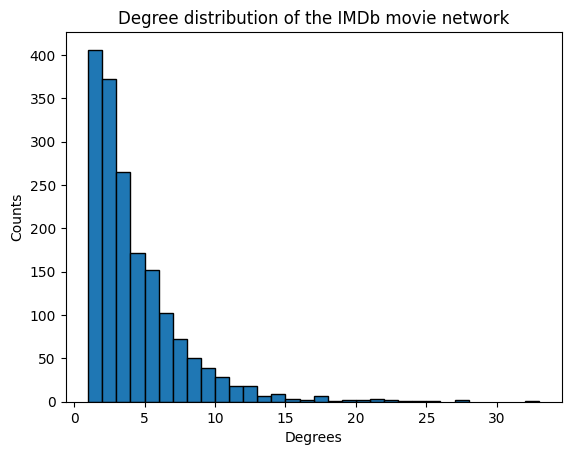

In [162]:
# Summary stats about the network
print(f"Number of nodes (movies): {G.number_of_nodes()}")
print(f"Number of edges (links between movies): {G.number_of_edges()}")
print(f"Number of unique actors linking movies: {len(actor_id_to_name)}")
print(f"Average degree: {np.mean([d for n, d in G.degree()])}")
print(f"Average rating: {np.mean([G.nodes[n]['avg_rating'] for n in G.nodes])}")

# Degree distribution
degree_dict = {}

for node in G.nodes():
    degree_dict[G.degree(node)] = degree_dict.get(G.degree(node), 0) + 1

plt.bar(degree_dict.keys(), degree_dict.values(), width=1, align='edge', edgecolor='black')
plt.xlabel('Degrees')
plt.ylabel('Counts')
plt.title('Degree distribution of the IMDb movie network')

In [163]:
# Highest degree nodes
sorted_degrees = sorted(G.degree(), key=lambda x: x[1], reverse=True)
print("Top 10 movies by degree:")
for movie_id, degree in sorted_degrees[:10]:
	print(f"{G.nodes[movie_id]['title']} (Degree: {degree})")

Top 10 movies by degree:
Avengers: Endgame (Degree: 32)
Spider-Man: No Way Home (Degree: 27)
The Dark Knight Rises (Degree: 27)
Goodfellas (Degree: 25)
Forrest Gump (Degree: 24)
The Dark Knight (Degree: 23)
Fight Club (Degree: 22)
X-Men: Days of Future Past (Degree: 22)
Mulan (Degree: 21)
Batman Begins (Degree: 21)


We now extract a subset of the network to visualize it

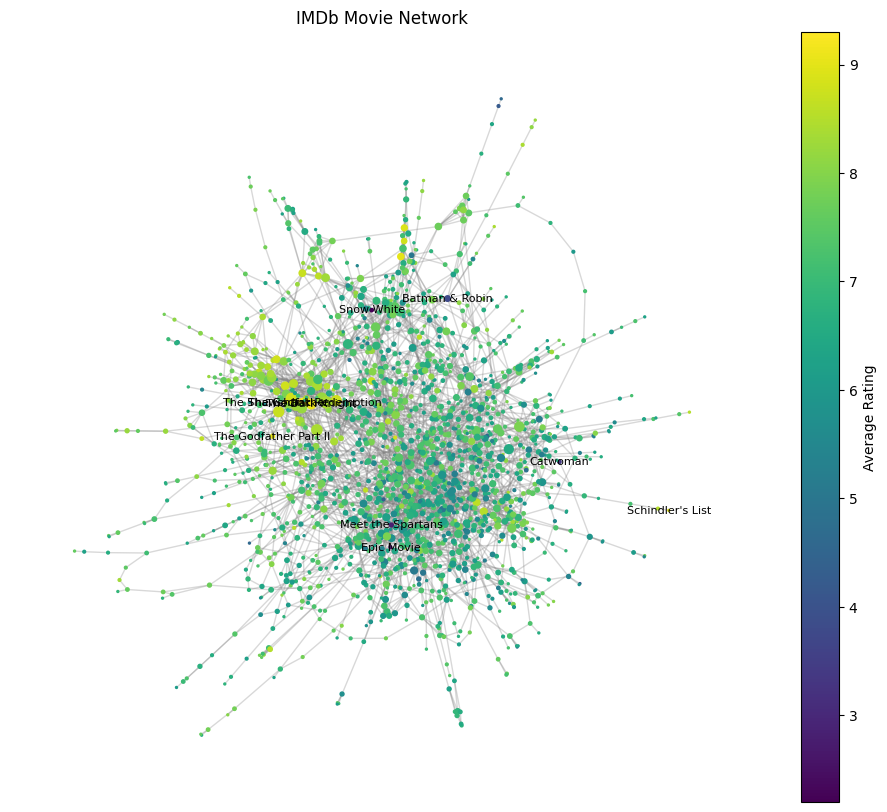

In [ ]:
# Visualization:

# Layout
pos = nx.forceatlas2_layout(G, max_iter=500, jitter_tolerance=0.2, scaling_ratio=1.0, gravity=1.0, seed=seed)

# Node sizing based on degree
deg = dict(G.degree())
node_sizes = [deg[n]*2 for n in G.nodes()]

# Color based on average rating
ratings = [G.nodes[n]['avg_rating'] for n in G.nodes()]

plt.figure(figsize=(12, 10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=ratings, cmap=plt.cm.viridis)
edges = nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
plt.colorbar(nodes, label='Average Rating')
plt.title("IMDb Movie Network")
plt.axis("off")
plt.show()

In [165]:
# We use the weight attribute (number of shared actors) to extract the backbone of the network
# Convert graph to pd dataframe
edge_data = nx.to_pandas_edgelist(G, source='src', target='trg')
# Store in file
edge_data.to_csv("edge_data.csv", sep='\t')
# load from file
table, num_nodes, num_edges = backboning.read("edge_data.csv","weight")
# noise correction
nc_table = backboning.noise_corrected(table)
# extract backbone
bb_table = backboning.thresholding(nc_table, 50.0)
# Create backbone graph
bb_graph = nx.from_pandas_edgelist(bb_table, source='src', target='trg', edge_attr='nij')
print(f"Backbone has {bb_table.shape[0]} edges out of {table.shape[0]} total edges.")

Backbone has 3175 edges out of 3373 total edges.


Calculating NC score...


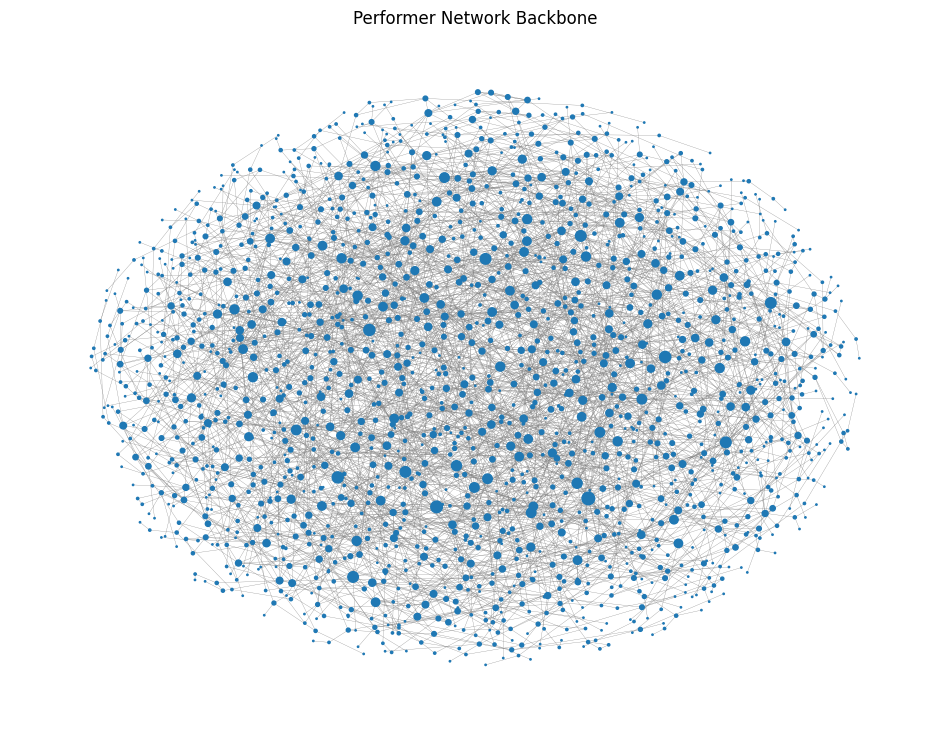

In [166]:
# Create backbone graph
bb_graph = nx.from_pandas_edgelist(bb_table, source='src', target='trg', edge_attr='nij')

# Ensure nice layout
pos = nx.forceatlas2_layout(bb_graph, max_iter=100, jitter_tolerance=0.5, scaling_ratio=1.0, gravity=1.0, strong_gravity=True, seed=seed)

# Use degree for node sizes
node_sizes = [bb_graph.degree[n]**1.5 for n in bb_graph.nodes()]

plt.figure(figsize=(12, 9))
# Firstly, draw the node interactivily
nodes = nx.draw_networkx_nodes(bb_graph, pos,node_size=node_sizes)
# Secondly, draw the edges
nx.draw_networkx_edges(bb_graph, pos, edge_color="gray", width=0.2)
# Thirdly, add labels to larger nodes
# labels = {n: n for n in bb_graph.nodes() if bb_graph.degree[n] > 8}
# nx.draw_networkx_labels(bb_graph, pos, font_size=6, verticalalignment='top')

plt.title("Performer Network Backbone")
plt.axis("off")
plt.show()